# Weather relation to cities coordinates

## Dependecies and configuration

In [7]:
# Import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

from scipy import stats
from datetime import date, datetime

# Import keys.
from api_keys import weather_api_key
from api_keys import g_key

# Dataset location.
cities_json_file_path = os.path.join('Resources', 'city.list.json')

# Output file for 1000 unique cities (is good sample out of 200K cities)
one_thousand_unique_cities_path = os.path.join('output', 'one_thousand_unique_cities.csv')

# Weather API configuration
weather_api_url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Base query URL
base_weather_data_for_a_city_url = f"{weather_api_url}appid={weather_api_key}&units={units}"


### Functions

In [2]:
# Get middle point
def get_middle_point(a_series):
    middle = ((a_series.max() + a_series.min() ) / 2)
    return middle

# Print scatter plot and save the plot as an image
def print_scatter_plot_with_regression_equation(x_series, y_series, marker, title, y_label, x_label, file_name, regress_values = None, line_eq = None):
    
    # Build scatter plot
    plt.scatter(x_series, y_series, marker = marker)
    
    if regress_values is not None:
        # Build line equation and annotate it to the scatter plot
        plt.plot(x_series, regress_values, "r-")
        plt.annotate(line_eq, (get_middle_point(x_series), get_middle_point(y_series)), fontsize = 15, color = "red")
    
    # Incorporate the other graph properties
    plt.title(f"{title} - {date.today()}")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.grid(True)
    
    # Save the figure
    plt.savefig(f"output/{file_name}-{date.today()}.png")
    
    # Show plot
    plt.show()

# Perform linear regression. Return regressed values, the linear equation and the r-value
def linear_regression_with_equation(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    
    # Print r square value
    print(f"The r-squared is: {rvalue**2}")
    
    return regress_values, line_equation

## Load dataset of cities and prepare sample dataframe

In [3]:
# Read cities dataset.
cities_df = pd.read_json(cities_json_file_path)

cities_coordinates = pd.json_normalize(cities_df['coord'])

cities_df = cities_df.merge(cities_coordinates, left_index = True, right_index = True) 
cities_df.drop(columns = ['coord'], inplace = True)

total_cities_count = cities_df['id'].unique()
print(f'Number of cities loaded: {len(total_cities_count)}')

Number of cities loaded: 209579


### Preparing sample of cities dataframe

In [4]:
# Divide cities in four groups.
# Each group will be made using the main imaginary lines dividing the Earth (the Prime meridian and the Equator).

# Cities in the first quadrant (longitude is negative and latitude is positive)
first_quadrant_cities = (cities_df['lon'] < 0) & (cities_df['lat'] > 0)
first_quadrant_cities_df = cities_df.loc[first_quadrant_cities]

# Cities in the second quadrant (both longitude and latitude are positive)
second_quadrant_cities = (cities_df['lon'] > 0) & (cities_df['lat'] > 0)
second_quadrant_cities_df = cities_df.loc[second_quadrant_cities]

# Cities in the third quadrant (both longitude and latitude are negative)
third_quadrant_cities = (cities_df['lon'] < 0) & (cities_df['lat'] < 0)
third_quadrant_cities_df = cities_df.loc[third_quadrant_cities]

# Cities in the fourth quadrant (longitude is positive and latitude is negative)
fourth_quadrant_cities = (cities_df['lon'] > 0) & (cities_df['lat'] < 0)
fourth_quadrant_cities_df = cities_df.loc[fourth_quadrant_cities]

# Get 1000 random unique cities in the world
temp_df = first_quadrant_cities_df.sample(n = 250)
one_thousand_cities = pd.DataFrame(temp_df)

temp_df = second_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

temp_df = third_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

temp_df = fourth_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

one_thousand_cities.reset_index(inplace = True)
one_thousand_cities = one_thousand_cities.drop(columns = ['index'])
one_thousand_cities.rename(columns={'id': 'city_id'}, inplace = True)
one_thousand_cities.rename(columns={'name': 'city_name'}, inplace = True)
one_thousand_cities = one_thousand_cities[['city_id', 'city_name', 'state', 'country', 'lat', 'lon']]

sample_cities_count = one_thousand_cities['city_id'].unique()
print(f'Number of sample cities: {len(sample_cities_count)}')

one_thousand_cities.head()

Number of sample cities: 1000


,city_id,city_name,state,country,lat,lon
0,5263045,Milwaukee,WI,US,43.038898,-87.906471
1,5260262,Little Chute,WI,US,44.279991,-88.318443
2,8010587,Penafiel,,PT,41.159599,-8.289720
3,2519945,Casas de Garcimolina,,ES,40.000000,-1.416670
4,2642763,Melton Mowbray,,GB,52.765881,-0.886930


## Start calculations and building plots

In [8]:
# Get weather data for all 1000 unique cities

counter = 0

print("Start data request...")

# Loop through the list of cities and perform a request for data on each
for index, city in one_thousand_cities.iterrows():
    id_param = f"&id={city['city_id']}"
    counter += 1
    
    print(f"{counter} - Getting weather data for: {city['city_id']} - {city['city_name']}, {city['country']} ... ")
    try:
        response = requests.get(base_weather_data_for_a_city_url + id_param).json()
        print(f"Data received.")
        
        one_thousand_cities.loc[index, 'temperature'] = response['main']['temp']
        one_thousand_cities.loc[index, 'humidity'] = response['main']['humidity']
        one_thousand_cities.loc[index, 'cloudiness'] = response['clouds']['all']
        one_thousand_cities.loc[index, 'wind_speed'] = response['wind']['speed']
        one_thousand_cities.loc[index, 'weather_condition'] = response['weather'][0]['main']
        one_thousand_cities.loc[index, 'weather_condition_desc'] = response['weather'][0]['description']
    except:
        print(f"There was an error retrieving this city weather data: {city['city_id']} - {city['city_name']}, {city['country']}")
    
    one_thousand_cities.loc[index, 'datetime'] = datetime.now()

print("Data request completed.")

one_thousand_cities.dropna(subset = ['temperature'], inplace = True)

one_thousand_cities.info()


Start data request...
1 - Getting weather data for: 5263045 - Milwaukee, US ... 
Data received.
2 - Getting weather data for: 5260262 - Little Chute, US ... 
Data received.
3 - Getting weather data for: 8010587 - Penafiel, PT ... 
Data received.
4 - Getting weather data for: 2519945 - Casas de Garcimolina, ES ... 
Data received.
5 - Getting weather data for: 2642763 - Melton Mowbray, GB ... 
Data received.
6 - Getting weather data for: 2509473 - Villatoya, ES ... 
Data received.
7 - Getting weather data for: 5038045 - Monticello, US ... 
Data received.
8 - Getting weather data for: 3212434 - Paraiso, PT ... 
Data received.
9 - Getting weather data for: 6362424 - Sestao, ES ... 
Data received.
10 - Getting weather data for: 4458601 - Caldwell County, US ... 
Data received.
11 - Getting weather data for: 4666265 - Weakley County, US ... 
Data received.
12 - Getting weather data for: 2638443 - Scales, GB ... 
Data received.
13 - Getting weather data for: 2263326 - São João da Talha, PT ..

Data received.
109 - Getting weather data for: 2643538 - Lower Beeding, GB ... 
Data received.
110 - Getting weather data for: 3601999 - San Juan de Flores, HN ... 
Data received.
111 - Getting weather data for: 6358079 - Villaseca de Henares, ES ... 
Data received.
112 - Getting weather data for: 4566467 - Padilla, PR ... 
Data received.
113 - Getting weather data for: 6616355 - Plourin-lès-Morlaix, FR ... 
Data received.
114 - Getting weather data for: 3702548 - Potrerillos Arriba, PA ... 
Data received.
115 - Getting weather data for: 2991879 - Morbihan, FR ... 
Data received.
116 - Getting weather data for: 6359385 - Valverde de Alcalá, ES ... 
Data received.
117 - Getting weather data for: 7294422 - Abergele, GB ... 
Data received.
118 - Getting weather data for: 4171522 - Saint Pete Beach, US ... 
Data received.
119 - Getting weather data for: 3016086 - Giéville, FR ... 
Data received.
120 - Getting weather data for: 6440371 - Espéchède, FR ... 
Data received.
121 - Getting weath

Data received.
215 - Getting weather data for: 5031749 - Janesville, US ... 
Data received.
216 - Getting weather data for: 3591629 - Parramos, GT ... 
Data received.
217 - Getting weather data for: 2521207 - Beas de Segura, ES ... 
Data received.
218 - Getting weather data for: 4568012 - Sabana Eneas, PR ... 
Data received.
219 - Getting weather data for: 6362537 - Losacio, ES ... 
Data received.
220 - Getting weather data for: 3112568 - Quincoces de Yuso, ES ... 
Data received.
221 - Getting weather data for: 8010429 - Sever do Vouga, PT ... 
Data received.
222 - Getting weather data for: 2510923 - Serrejón, ES ... 
Data received.
223 - Getting weather data for: 4760084 - City of Fredericksburg, US ... 
Data received.
224 - Getting weather data for: 4949245 - Rutland, US ... 
Data received.
225 - Getting weather data for: 5186053 - Croydon, US ... 
Data received.
226 - Getting weather data for: 2654591 - Bromfield, GB ... 
Data received.
227 - Getting weather data for: 4204241 - LaFa

Data received.
323 - Getting weather data for: 1510960 - Balgazyn, RU ... 
Data received.
324 - Getting weather data for: 2831948 - Sindelfingen, DE ... 
Data received.
325 - Getting weather data for: 733347 - Beli Breg, BG ... 
Data received.
326 - Getting weather data for: 2798555 - Evere, BE ... 
Data received.
327 - Getting weather data for: 2033111 - Mishan, CN ... 
Data received.
328 - Getting weather data for: 390054 - Kūh Sefīd, IR ... 
Data received.
329 - Getting weather data for: 2656161 - Battle, GB ... 
Data received.
330 - Getting weather data for: 714081 - Verpelét, HU ... 
Data received.
331 - Getting weather data for: 6548189 - Holdorf, DE ... 
Data received.
332 - Getting weather data for: 2887390 - Kloster Zinna, DE ... 
Data received.
333 - Getting weather data for: 669647 - Prigor, RO ... 
Data received.
334 - Getting weather data for: 2659470 - Niederbipp, CH ... 
Data received.
335 - Getting weather data for: 6535637 - Massa di Somma, IT ... 
Data received.
336 -

Data received.
431 - Getting weather data for: 1616593 - Ban Muang Chet Ton, TH ... 
Data received.
432 - Getting weather data for: 6436800 - Piennes, FR ... 
Data received.
433 - Getting weather data for: 6416078 - Botvinino, RU ... 
Data received.
434 - Getting weather data for: 2766580 - Sankt Lorenzen bei Knittelfeld, AT ... 
Data received.
435 - Getting weather data for: 605387 - Kalix Kommun, SE ... 
Data received.
436 - Getting weather data for: 2993023 - Arrondissement de Montargis, FR ... 
Data received.
437 - Getting weather data for: 3177582 - Dimaro, IT ... 
Data received.
438 - Getting weather data for: 6535001 - Alonte, IT ... 
Data received.
439 - Getting weather data for: 2802359 - Belgrade, BE ... 
Data received.
440 - Getting weather data for: 3170404 - Polcenigo, IT ... 
Data received.
441 - Getting weather data for: 1254757 - Tenāli, IN ... 
Data received.
442 - Getting weather data for: 2865073 - Neuhäuser, DE ... 
Data received.
443 - Getting weather data for: 169

Data received.
537 - Getting weather data for: 4035013 - Solosolo, WS ... 
Data received.
538 - Getting weather data for: 3904906 - Santa Cruz de la Sierra, BO ... 
Data received.
539 - Getting weather data for: 3865424 - Arroyito, AR ... 
Data received.
540 - Getting weather data for: 3453882 - Pimenta, BR ... 
Data received.
541 - Getting weather data for: 3448502 - São Mateus do Sul, BR ... 
Data received.
542 - Getting weather data for: 3429933 - Plátanos, AR ... 
Data received.
543 - Getting weather data for: 3409245 - Arame, BR ... 
Data received.
544 - Getting weather data for: 3929631 - San Isidro, PE ... 
Data received.
545 - Getting weather data for: 3435750 - Campo Viera, AR ... 
Data received.
546 - Getting weather data for: 3465164 - Cristalina, BR ... 
Data received.
547 - Getting weather data for: 3455784 - Orleans, BR ... 
Data received.
548 - Getting weather data for: 3446866 - Tapiramutá, BR ... 
Data received.
549 - Getting weather data for: 3437600 - Paraguarí, PY .

Data received.
644 - Getting weather data for: 3405851 - Belém do Brejo do Cruz, BR ... 
Data received.
645 - Getting weather data for: 3461633 - Iapu, BR ... 
Data received.
646 - Getting weather data for: 3461742 - Guimarânia, BR ... 
Data received.
647 - Getting weather data for: 3401980 - Coité do Nóia, BR ... 
Data received.
648 - Getting weather data for: 3427565 - Vagues, AR ... 
Data received.
649 - Getting weather data for: 3844046 - Mojón, AR ... 
Data received.
650 - Getting weather data for: 3833947 - Trancas, AR ... 
Data received.
651 - Getting weather data for: 3849300 - Laprida, AR ... 
Data received.
652 - Getting weather data for: 3454369 - Pedro de Toledo, BR ... 
Data received.
653 - Getting weather data for: 3846374 - Los Cardos, AR ... 
Data received.
654 - Getting weather data for: 3457623 - Marques de Souza, BR ... 
Data received.
655 - Getting weather data for: 3436058 - Departamento de Bella Vista, AR ... 
Data received.
656 - Getting weather data for: 3844104

Data received.
751 - Getting weather data for: 2163341 - Hockley, AU ... 
Data received.
752 - Getting weather data for: 1636825 - Maja, ID ... 
Data received.
753 - Getting weather data for: 8190883 - Kemuningsari, ID ... 
Data received.
754 - Getting weather data for: 2166008 - Furner, AU ... 
Data received.
755 - Getting weather data for: 1063858 - Ivato, MG ... 
Data received.
756 - Getting weather data for: 2160495 - Lavers Hill, AU ... 
Data received.
757 - Getting weather data for: 1633196 - Pakenjeng, ID ... 
Data received.
758 - Getting weather data for: 7839657 - Albany, AU ... 
Data received.
759 - Getting weather data for: 2168029 - Durham Lead, AU ... 
Data received.
760 - Getting weather data for: 193980 - Kapsuset, KE ... 
Data received.
761 - Getting weather data for: 2169535 - Dalby, AU ... 
Data received.
762 - Getting weather data for: 2174667 - Boort, AU ... 
Data received.
763 - Getting weather data for: 2164934 - Goornong, AU ... 
Data received.
764 - Getting weat

Data received.
859 - Getting weather data for: 8023807 - Ampera, ID ... 
Data received.
860 - Getting weather data for: 2164408 - Grong Grong, AU ... 
Data received.
861 - Getting weather data for: 1062947 - Republic of Madagascar, MG ... 
Data received.
862 - Getting weather data for: 2143737 - Whorouly, AU ... 
Data received.
863 - Getting weather data for: 2005237 - Kasihan, ID ... 
Data received.
864 - Getting weather data for: 1637001 - Luwuk, ID ... 
Data received.
865 - Getting weather data for: 2153726 - Parwan, AU ... 
Data received.
866 - Getting weather data for: 2056910 - Wahang Dua, ID ... 
Data received.
867 - Getting weather data for: 214974 - Kalemie, CD ... 
Data received.
868 - Getting weather data for: 2147276 - Tatong, AU ... 
Data received.
869 - Getting weather data for: 8058433 - Tambakromo, ID ... 
Data received.
870 - Getting weather data for: 1641977 - Kalianget, ID ... 
Data received.
871 - Getting weather data for: 8022647 - Tambakbaya, ID ... 
Data received

Data received.
969 - Getting weather data for: 7839579 - Fraser Coast, AU ... 
Data received.
970 - Getting weather data for: 1639215 - Kudus, ID ... 
Data received.
971 - Getting weather data for: 8058198 - Mantingan, ID ... 
Data received.
972 - Getting weather data for: 2163996 - Hampstead, AU ... 
Data received.
973 - Getting weather data for: 2178081 - Allansford, AU ... 
Data received.
974 - Getting weather data for: 7767017 - Sumberwaras, ID ... 
Data received.
975 - Getting weather data for: 2165405 - Glenbrae, AU ... 
Data received.
976 - Getting weather data for: 2060579 - Tarlee, AU ... 
Data received.
977 - Getting weather data for: 7559741 - Weepanapi, ID ... 
Data received.
978 - Getting weather data for: 2148499 - Stapylton, AU ... 
Data received.
979 - Getting weather data for: 7381978 - Nae, ID ... 
Data received.
980 - Getting weather data for: 7839353 - Central Coast, AU ... 
Data received.
981 - Getting weather data for: 2181100 - Tirau, NZ ... 
Data received.
982 -

## Save data in CSV format

In [9]:
one_thousand_cities.to_csv(one_thousand_unique_cities_path, index = False, header = True)


## Create scatter plots

### Scatter plots

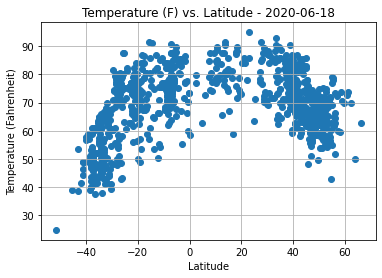

In [10]:
# Temperature (F) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["temperature"],
    "o",
    "Temperature (F) vs. Latitude",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude"
)

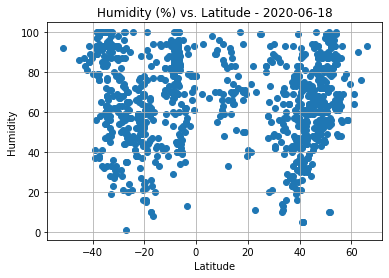

In [11]:
# Humidity (%) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["humidity"],
    "o",
    "Humidity (%) vs. Latitude",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude"
)

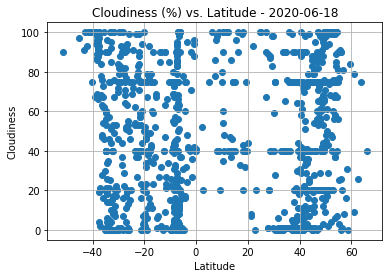

In [12]:
# Cloudiness (%) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude"
)

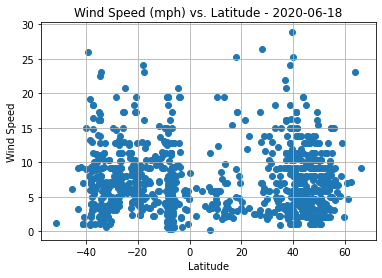

In [13]:
# Wind Speed (mph) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude"
)

### Linear regression by Hemisphere

In [14]:
# Divide cities by hemispheres

northern_hemisphere_df = one_thousand_cities.loc[one_thousand_cities['lat'] > 0]
southern_hemisphere_df = one_thousand_cities.loc[one_thousand_cities['lat'] < 0]


The r-squared is: 0.3086330873338328


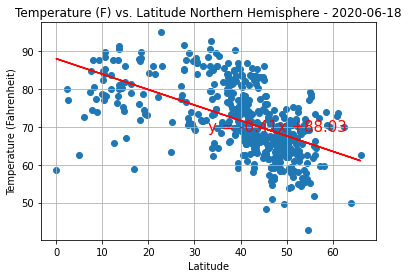

The r-squared is: 0.5069201782913703


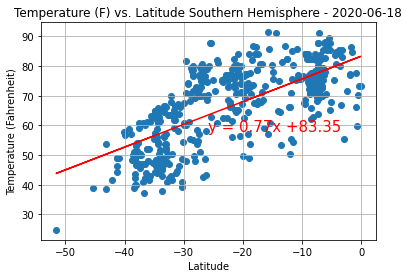

In [15]:
# Perform a linear regression on temperature vs. latitude for the northern hemisphere

(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["temperature"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["temperature"],
    "o",
    "Temperature (F) vs. Latitude Northern Hemisphere",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on temperature vs. latitude for the southern hemisphere

(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["temperature"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["temperature"],
    "o",
    "Temperature (F) vs. Latitude Southern Hemisphere",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude-SH",
    regress_values,
    line_eq
)


The r-squared is: 0.0024849375541469063


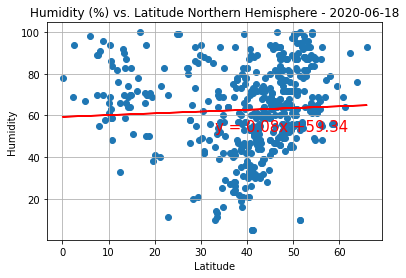

The r-squared is: 0.002937274222168409


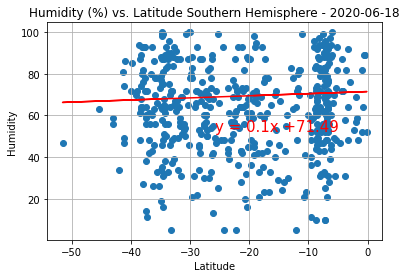

In [16]:
# Perform a linear regression on Humidity (%) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["humidity"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["humidity"],
    "o",
    "Humidity (%) vs. Latitude Northern Hemisphere",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Humidity (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["humidity"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["humidity"],
    "o",
    "Humidity (%) vs. Latitude Southern Hemisphere",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude-SH",
    regress_values,
    line_eq
)

The r-squared is: 0.0003794429320476639


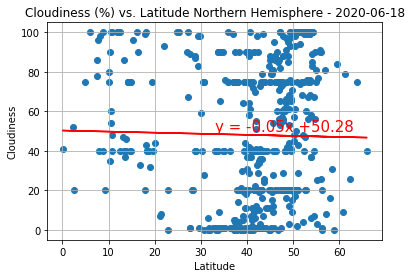

The r-squared is: 0.031416680869576684


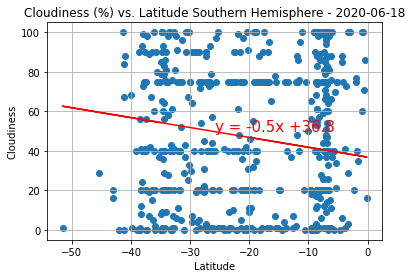

In [17]:
# Perform a linear regression on Cloudiness (%) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["cloudiness"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude Northern Hemisphere",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Cloudiness (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["cloudiness"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude Southern Hemisphere",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude-SH",
    regress_values,
    line_eq
)

The r-squared is: 0.0004608993780270743


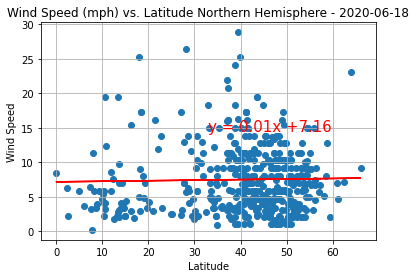

The r-squared is: 0.0043710859163224505


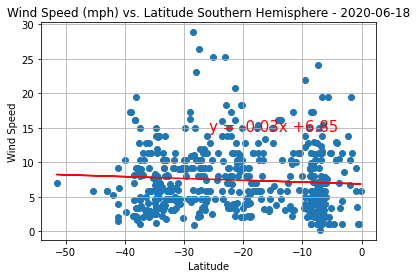

In [18]:
# Perform a linear regression on Wind Speed (mph) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["wind_speed"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude Northern Hemisphere",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Wind Speed (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["wind_speed"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude Southern Hemisphere",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude-SH",
    regress_values,
    line_eq
)